In [293]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go

In [58]:
from summer2 import CompartmentalModel, Stratification, Multiply
from summer2.parameters import Parameter
from summer2.functions import get_piecewise_scalar_function

**Model 2: SEIQR (Stratified Infectious Compartment)**

In [236]:
def build_model():
    m = CompartmentalModel([0,100], ["S","E","I","Q","R"],"I",ref_date=datetime(2020,6,1))
    m.set_initial_population({"S": 13781001.0, "E": 832.0 , "I": 1153.0, "Q": 3622.0, "R": 14178.0})
    m.add_infection_frequency_flow("infection", get_piecewise_scalar_function([Parameter("breakpt1"),Parameter("breakpt2")], [Parameter("rate1"),Parameter("rate2"),Parameter("rate3")]),"S","E") 
    m.add_transition_flow("progression", 0.2,"E","I")
    m.add_transition_flow("notification", Parameter("detection_rate"),"I","Q")
    m.add_transition_flow("recovery_from_Q", 0.0714,"Q","R") 
    m.add_transition_flow("recovery__from_I", 0.0714,"I","R") 
    m.add_death_flow("infection_death", Parameter("death_rate"), "I")
    m.request_output_for_flow("infection", "infection")
    m.request_output_for_flow("notification", "notification")
    m.request_output_for_flow("infection_death", "infection_death")
    m.request_cumulative_output(name="deaths_cumulative", source="infection_death")
    m.request_output_for_compartments(name="active", compartments=["Q"])

    strata = ["asymptomatic", "symptomatic"]
    strat = Stratification(name="severity", strata=strata, compartments=['I'])

    strat.set_population_split({"asymptomatic": 0.18, "symptomatic": 0.82})

    strat.set_flow_adjustments("progression", {
    "asymptomatic": None,
    "symptomatic": Multiply(Parameter("symp_prop")),
    })

    strat.set_flow_adjustments("notification", {
    "asymptomatic": Multiply(Parameter("asymp_det")),
    "symptomatic": None,
    })

    strat.set_flow_adjustments("infection_death", {
    "asymptomatic": Multiply(Parameter("asymp_death")),
    "symptomatic": None,
    })

    return m, strat

In [237]:
m, strat = build_model()
m.stratify_with(strat)

/var/folders/58/qy67y27x0jsd0h0bx4dmp2yw0000gn/T/ipykernel_5243/4129430138.py:4: DeprecationWarning: This method is deprecated and scheduled for removal, use get_piecewise_function instead
  m.add_infection_frequency_flow("infection", get_piecewise_scalar_function([Parameter("breakpt1"),Parameter("breakpt2")], [Parameter("rate1"),Parameter("rate2"),Parameter("rate3")]),"S","E")


In [238]:
parameters = {"breakpt1": 20, "breakpt2": 30, "rate1": 0.3, "rate2": 0.2, "rate3": 0.25, "detection_rate": 0.1, "symp_prop": 4.0, "asymp_det": 0.2, "death_rate": 0.01, "asymp_death": 0.3}

In [239]:
m.run(parameters)

In [288]:
fig = px.line(m.get_outputs_df())
fig.show()

/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<Axes: >

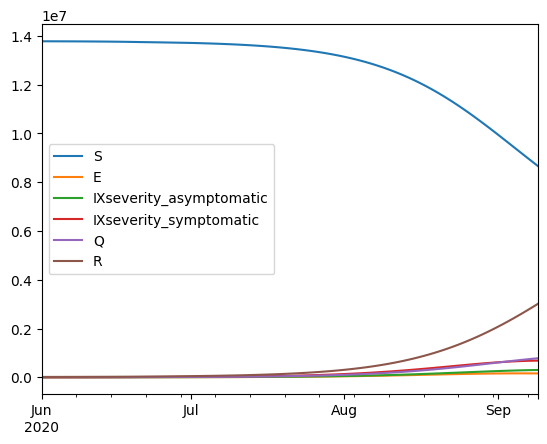

In [240]:
m.get_outputs_df().plot()

<Axes: >

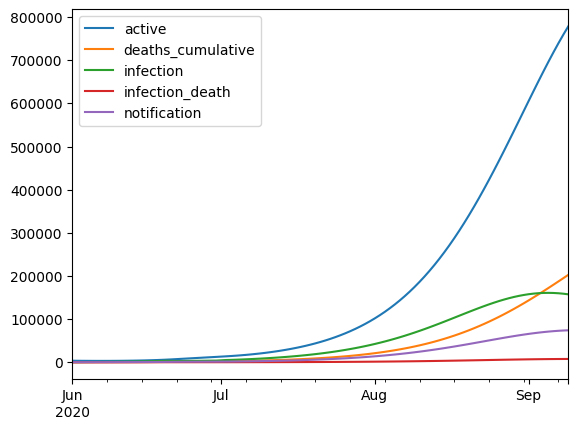

In [241]:
m.get_derived_outputs_df().plot()

In [242]:
df=pd.read_excel(io='InfectionsData_060120_093020.xlsx',index_col=0)
notification_data = df["7-DAY MA"]
death_data = df["CUMULATIVE DEATHS"]

In [243]:
notification_data

DATE
2020-06-01     326.000000
2020-06-02     314.571429
2020-06-03     314.714286
2020-06-04     306.000000
2020-06-05     230.000000
                 ...     
2020-09-26    1036.285714
2020-09-27     997.285714
2020-09-28     984.428571
2020-09-29     989.285714
2020-09-30     943.571429
Name: 7-DAY MA, Length: 122, dtype: float64

In [244]:
notification_data_cal = notification_data[31:70]
death_data_cal = death_data[31:70]

<Axes: xlabel='DATE'>

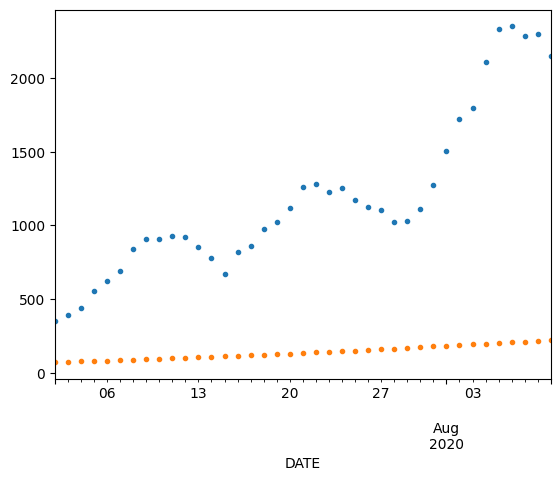

In [245]:
notification_data_cal.plot(style='.')
death_data_cal.plot(style='.')

**Calibration**

In [246]:
# Targets represent data we are trying to fit to
from estival import targets as est

# We specify parameters using (Bayesian) priors
from estival import priors as esp

# Finally we combine these with our summer2 model in a BayesianCompartmentalModel (BCM)
from estival.model import BayesianCompartmentalModel

In [247]:
targets = [
    #est.NormalTarget("notification", notification_data_cal, np.std(notification_data_cal) * 0.1)
    est.TruncatedNormalTarget("notification", notification_data_cal, (0.0,np.inf),
        esp.UniformPrior("notification_dispersion",(0.1, notification_data_cal.max()*0.1))),
    est.NormalTarget("deaths_cumulative", death_data_cal, np.std(death_data_cal) * 0.1)
]

In [248]:
priors = [
    esp.UniformPrior("breakpt1", (30,45)),
    esp.UniformPrior("breakpt2", (45,61)),
    esp.UniformPrior("rate1", (0.1,0.5)),
    esp.UniformPrior("rate2", (0.1,0.5)),
    esp.UniformPrior("rate3", (0.1,0.5)),
    esp.UniformPrior("detection_rate", (0.1,1)),
    esp.UniformPrior("symp_prop", (1,6)),
    esp.UniformPrior("asymp_det", (0,1)),
    esp.UniformPrior("death_rate", (0,0.1)),
    esp.UniformPrior("asymp_death", (0,0.7)),
]

In [249]:
defp = {"breakpt1": 30, "breakpt2": 30, "rate1": 0.2, "rate2": 0.2, "rate3": 0.2, "detection_rate":0.2, "symp_prop": 4, "asymp_det": 0.2, "death_rate": 0.01, "asymp_death": 0.5}

In [250]:
bcm = BayesianCompartmentalModel(m, defp, priors, targets)
from estival.wrappers import pymc as epm
import pymc as pm

In [251]:
with pm.Model() as model:

    # This is all you need - a single call to use_model
    variables = epm.use_model(bcm)

    # The log-posterior value can also be output, but may incur additional overhead
    # Use jacobian=False to get the unwarped value (ie just the 'native' density of the priors
    # without transformation correction factors)
    # pm.Deterministic("logp", model.logp(jacobian=False))

    # Now call a sampler using the variables from use_model
    # In this case we use the Differential Evolution Metropolis sampler
    # See the PyMC docs for more details
    idata = pm.sample(step=[pm.DEMetropolis(variables)], draws=12000, tune=0,cores=4,chains=12)

Population sampling (12 chains)
DEMetropolis: [breakpt1, breakpt2, rate1, rate2, rate3, detection_rate, symp_prop, asymp_det, death_rate, asymp_death, notification_dispersion]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.

Sampling 12 chains for 0 tune and 12_000 draw iterations (0 + 144_000 draws total) took 83 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Visualizing Outputs**

In [252]:
import arviz as az

In [253]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
breakpt1,39.351,4.040,32.228,44.988,0.545,0.387,55.0,82.0,1.16
breakpt2,52.782,4.512,45.935,60.547,0.785,0.560,31.0,28.0,1.30
rate1,0.377,0.072,0.252,0.487,0.015,0.010,31.0,26.0,1.30
rate2,0.374,0.087,0.212,0.498,0.010,0.007,77.0,90.0,1.12
rate3,0.397,0.086,0.236,0.500,0.012,0.009,58.0,236.0,1.14
detection_rate,0.473,0.186,0.253,0.978,0.043,0.033,23.0,14.0,1.48
symp_prop,2.717,1.307,1.000,5.219,0.177,0.126,54.0,117.0,1.16
asymp_det,0.373,0.259,0.061,0.998,0.054,0.042,24.0,20.0,1.44
death_rate,0.003,0.005,0.001,0.007,0.000,0.000,43.0,179.0,1.20
asymp_death,0.274,0.208,0.004,0.634,0.035,0.025,34.0,132.0,1.25


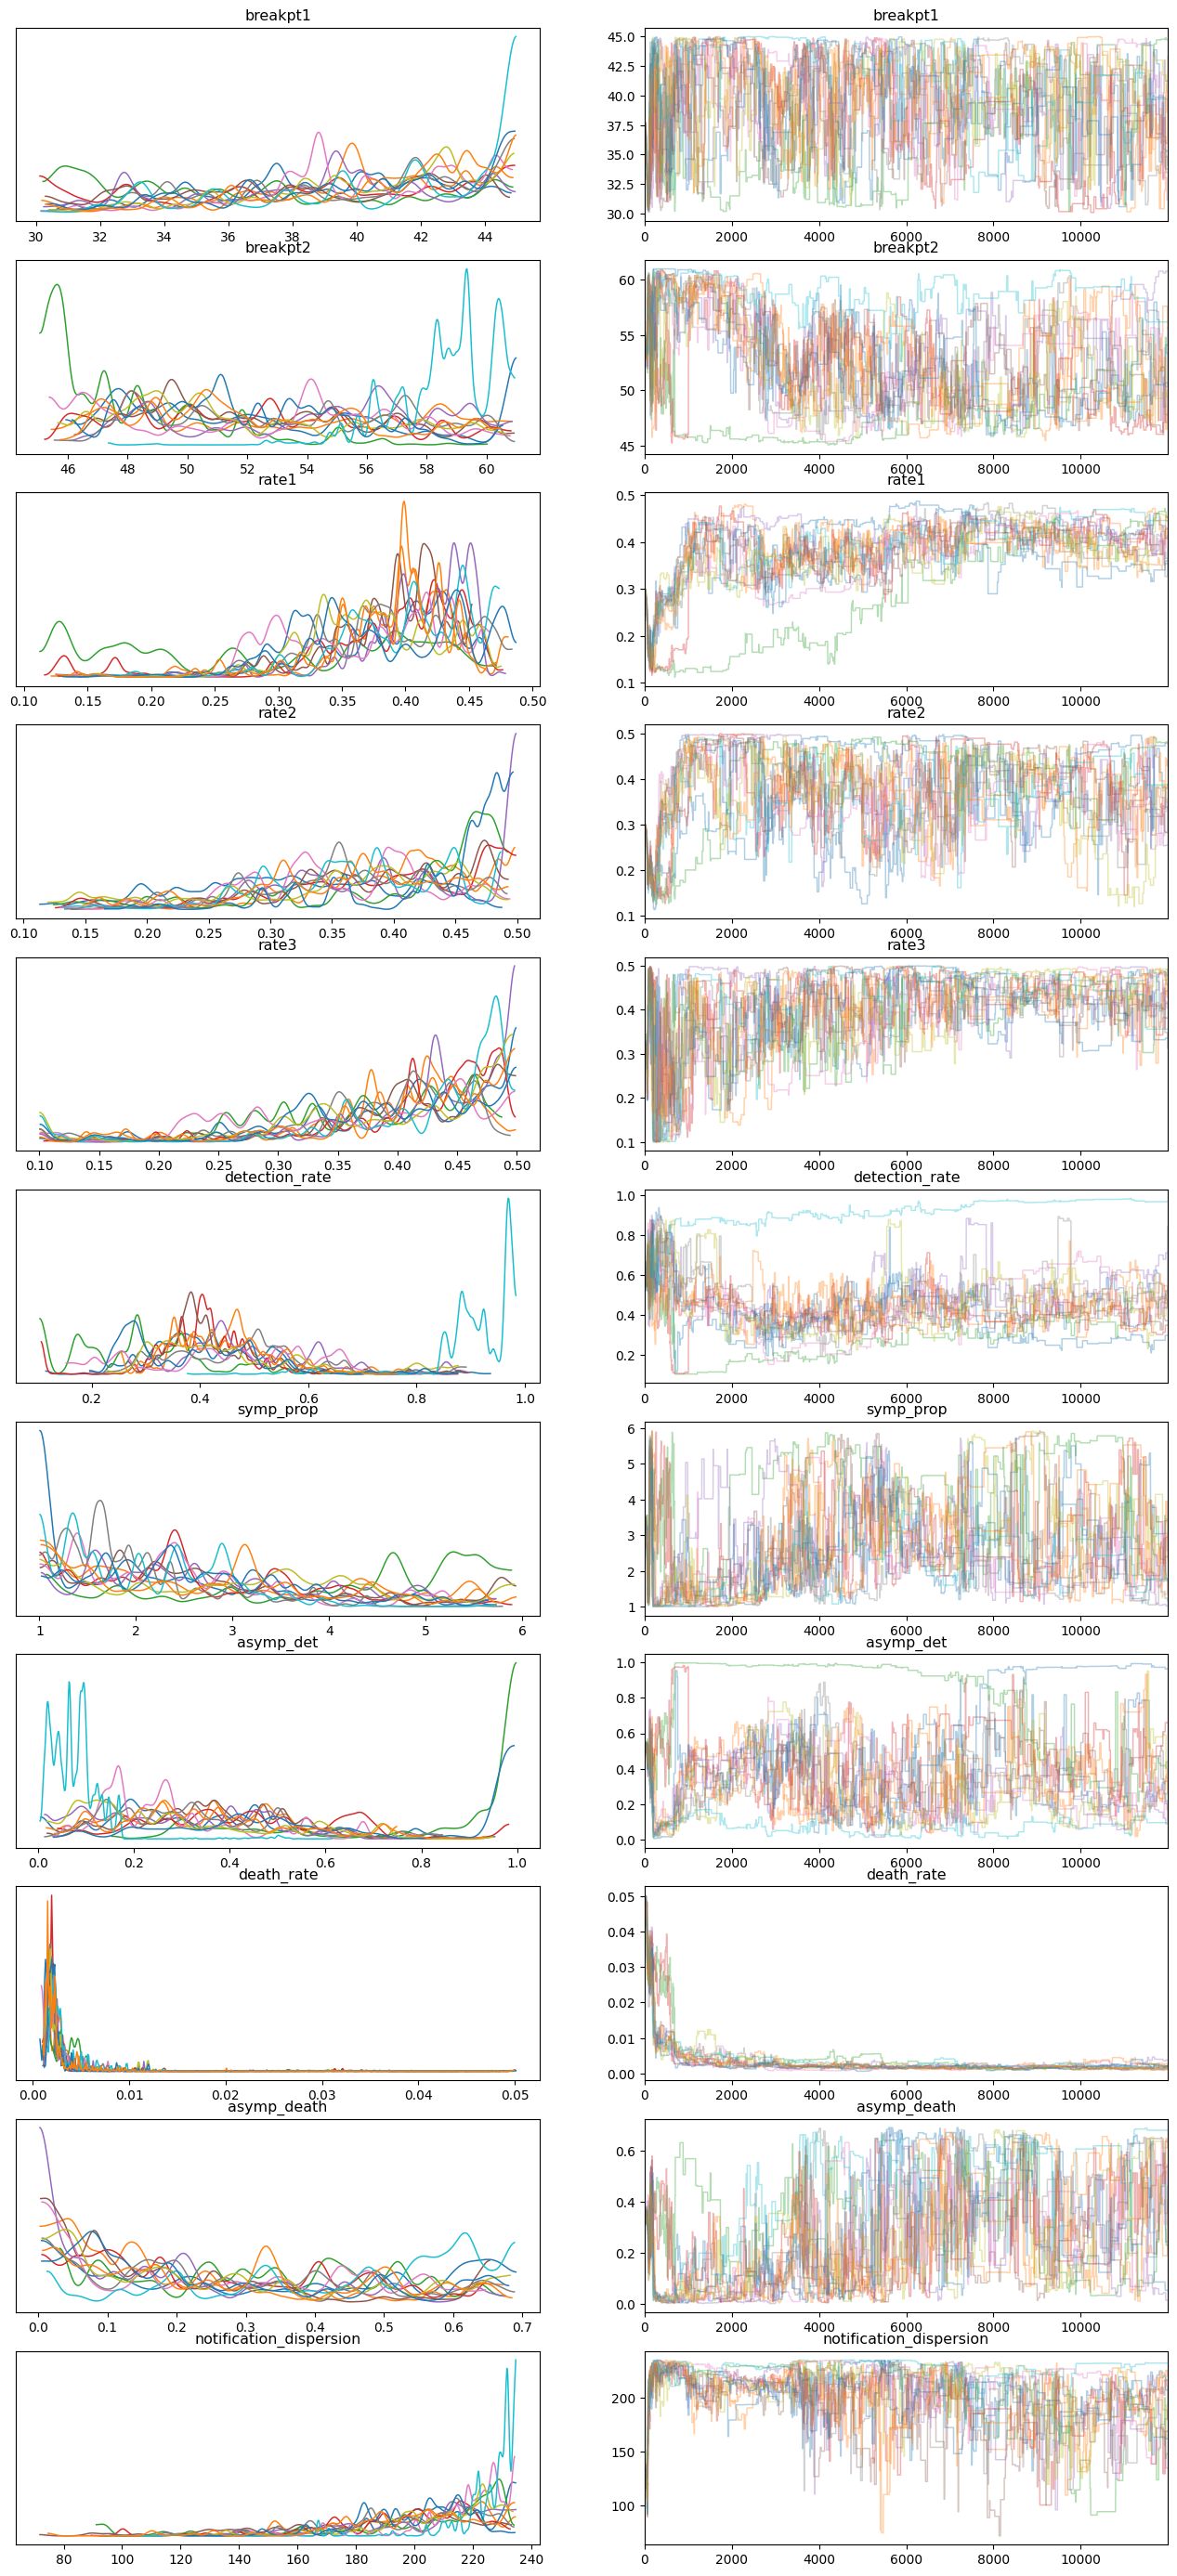

In [254]:
az.plot_trace(idata, figsize=(16,3.2*len(idata.posterior)),compact=False);#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

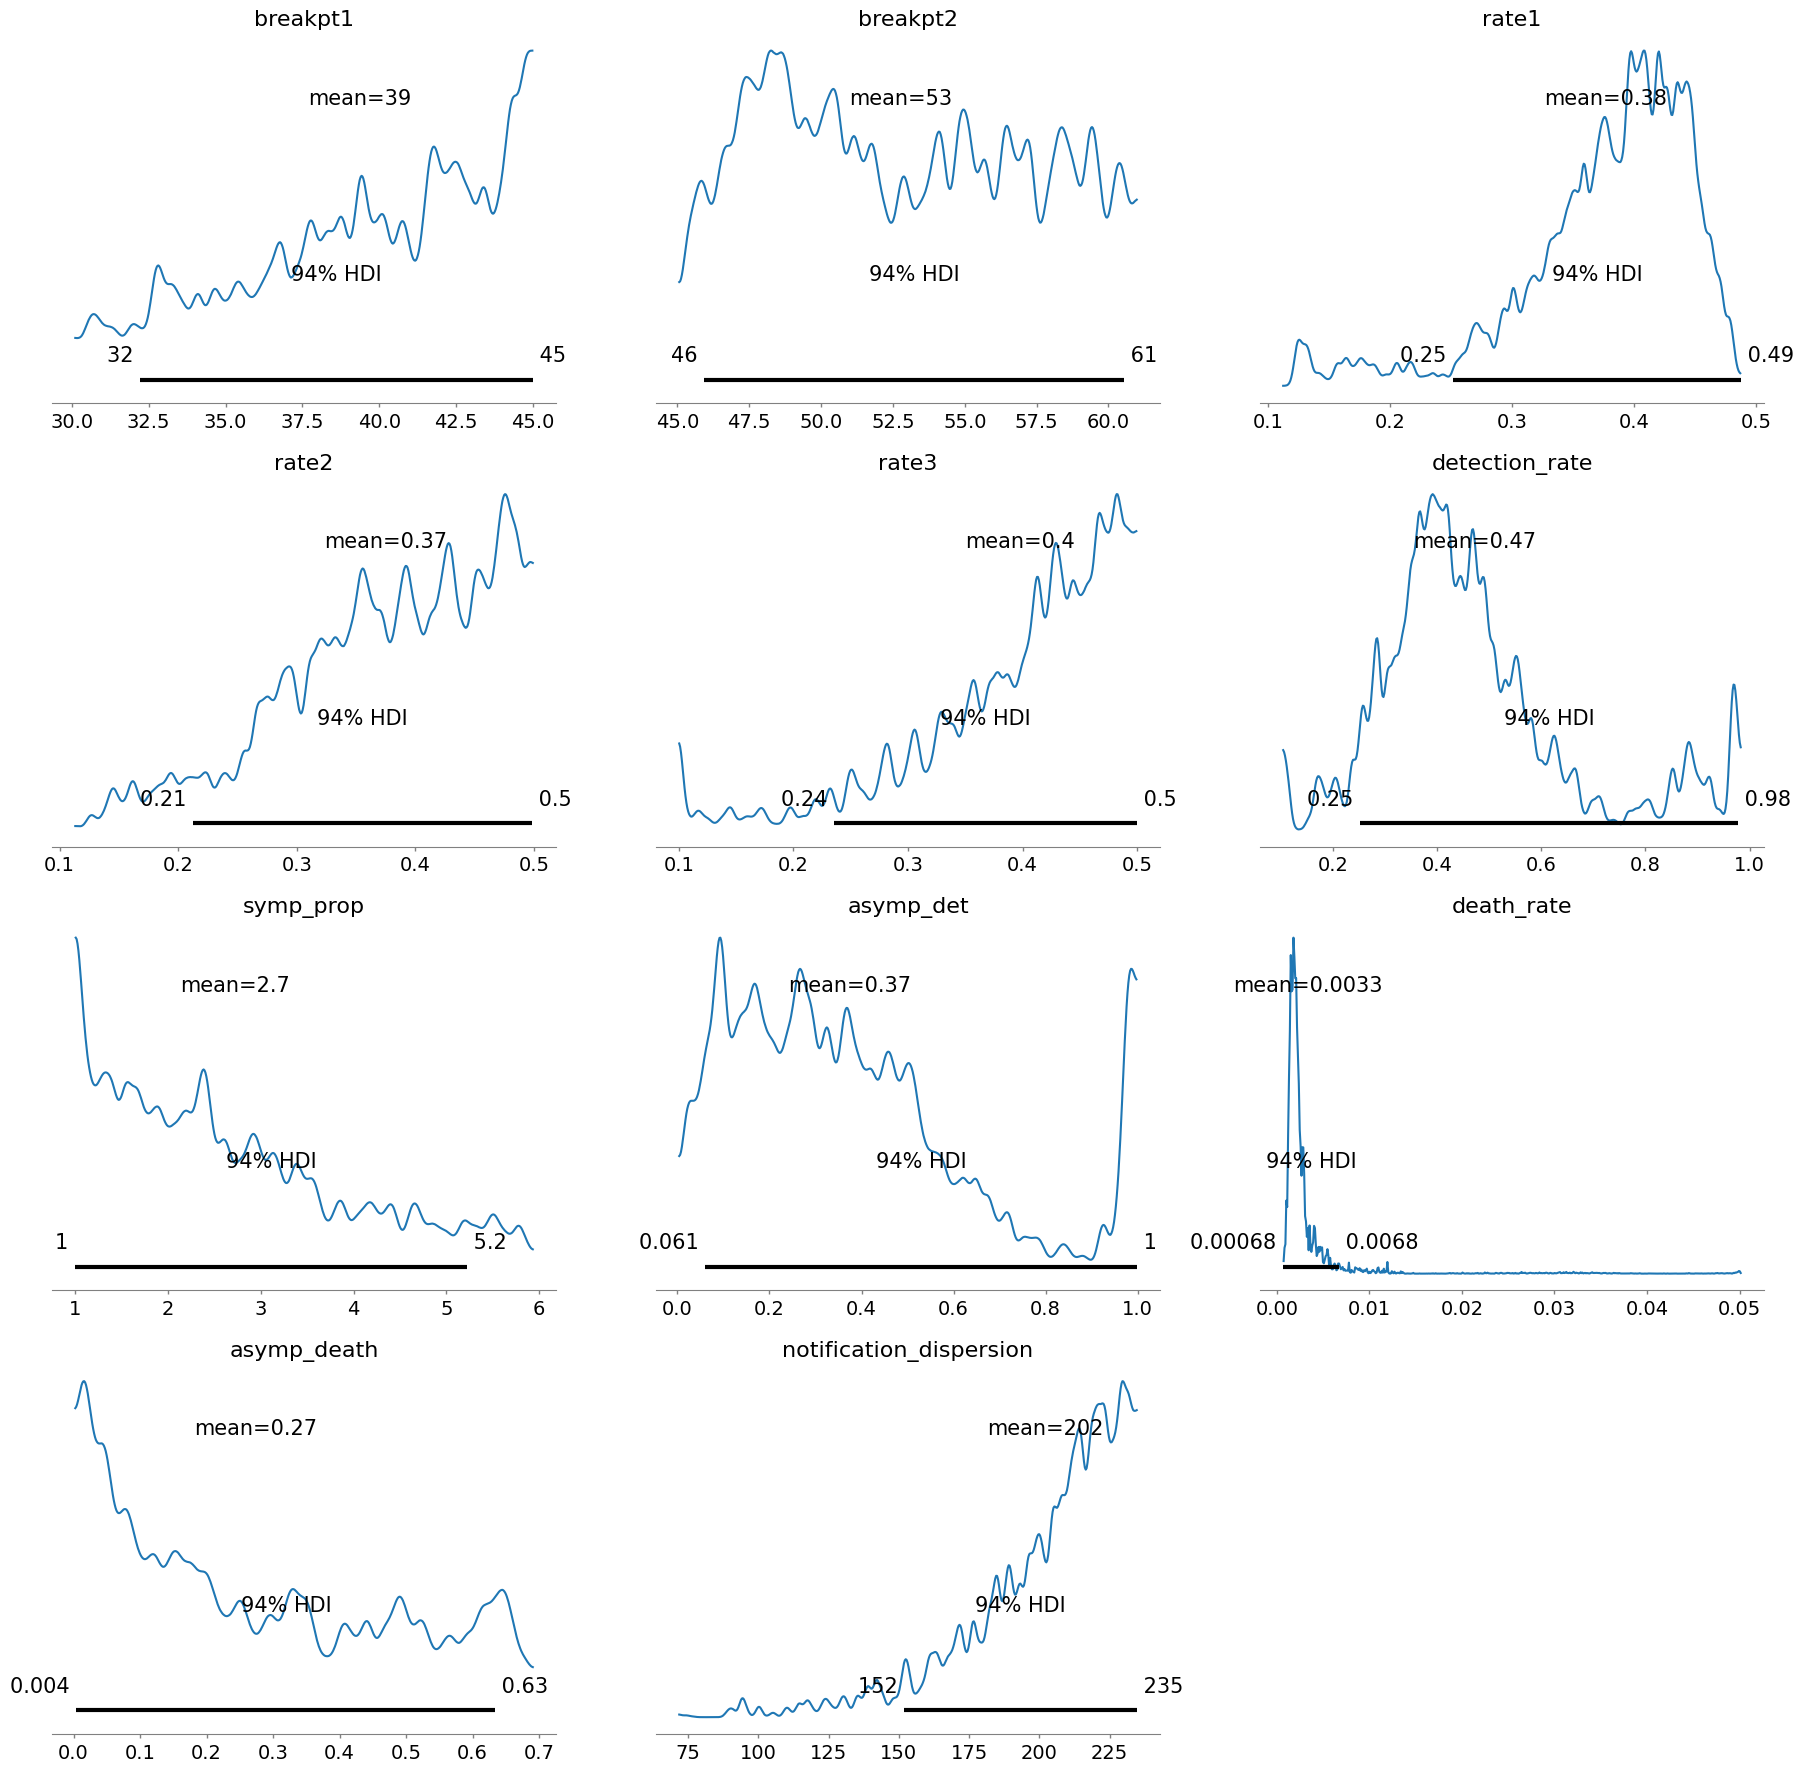

In [255]:
az.plot_posterior(idata);

**Obtaining Likelihood**

In [256]:
from estival.sampling.tools import likelihood_extras_for_idata

In [257]:
likelihood_df = likelihood_extras_for_idata(idata, bcm)

<Axes: xlabel='draw'>

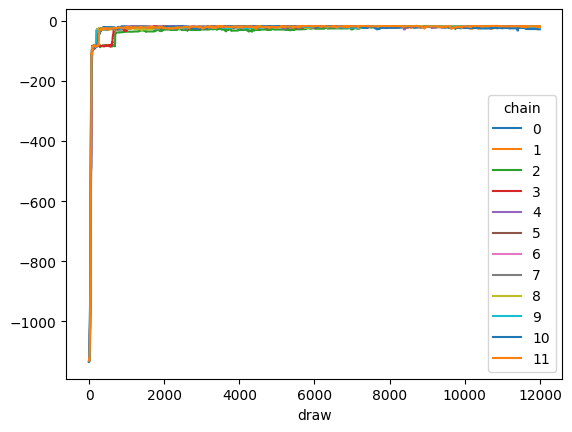

In [258]:
ldf_pivot = likelihood_df.reset_index(level="chain").pivot(columns=["chain"])

ldf_pivot["logposterior"].plot()

In [259]:
# Sort this DataFrame by logposterior to obtain the MAP index
ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)

# Extract the parameters from the calibration samples
map_params = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()

map_params

{'breakpt1': 40.9201670257455,
 'breakpt2': 46.11424960257349,
 'rate1': 0.4556536041909972,
 'rate2': 0.4549539665553707,
 'rate3': 0.47127702030587426,
 'detection_rate': 0.46408045623641453,
 'symp_prop': 5.140303582898726,
 'asymp_det': 0.29213444699296287,
 'death_rate': 0.0014088857605092657,
 'asymp_death': 0.6514422414286144,
 'notification_dispersion': 227.1488875552577}

In [260]:
bcm.loglikelihood(**map_params), ldf_sorted.iloc[0]["loglikelihood"]

(Array(-9.7997778, dtype=float64), -9.79977780052191)

In [261]:
map_res = bcm.run(map_params)

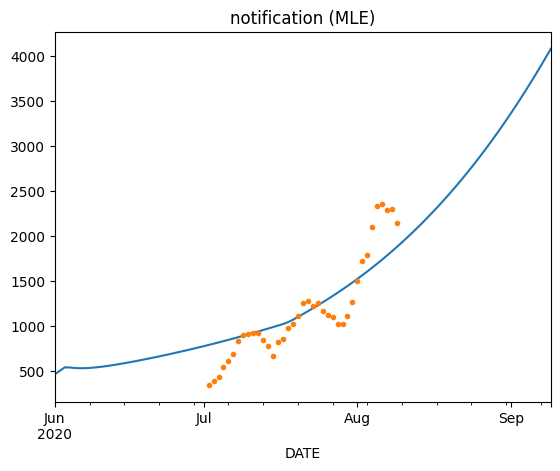

In [262]:
variable = "notification"

pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
bcm.targets[variable].data.plot(style='.');

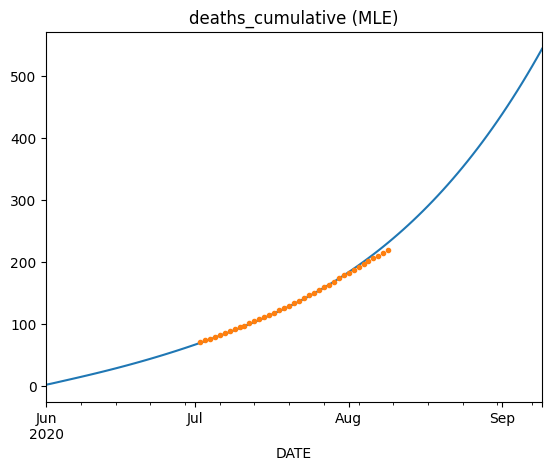

In [263]:
variable = "deaths_cumulative"

pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
bcm.targets[variable].data.plot(style='.');

**Compare with Actual Data for August 2020**

<Axes: title={'center': 'notification (MLE)'}, xlabel='DATE'>

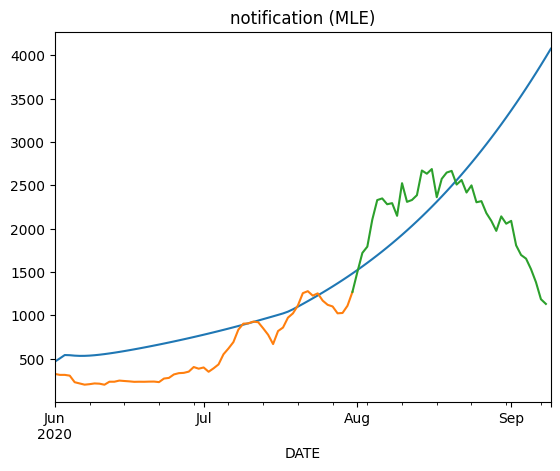

In [264]:
variable = "notification"

pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
notification_data[:61].plot()
notification_data[60:100].plot()

**Uncertainty Sampling**

In [265]:
sample_idata = az.extract(idata, num_samples = 400)
samples_df = sample_idata.to_dataframe().drop(columns=["chain","draw"])

In [266]:
from estival.utils.parallel import map_parallel

In [267]:
def run_sample(idx_sample):
    idx, params = idx_sample
    return idx, bcm.run(params)

In [268]:
sample_res = map_parallel(run_sample, samples_df.iterrows(), n_workers=4)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [269]:
import xarray as xr

In [270]:
xres = xr.DataArray(np.stack([r.derived_outputs for idx, r in sample_res]),
                    dims=["sample","time","variable"])
xres = xres.assign_coords(sample=sample_idata.coords["sample"],
                          time=map_res.derived_outputs.index, variable=map_res.derived_outputs.columns)

In [271]:
# Set some quantiles to calculate
quantiles = (0.01,0.05,0.25,0.5,0.75,0.95,0.99)

# Generate a new DataArray containing the quantiles
xquantiles = xres.quantile(quantiles,dim=["sample"])

In [272]:
# Extract these values to a pandas DataFrame for ease of plotting

uncertainty_df = xquantiles.to_dataframe(name="value").reset_index().set_index("time").pivot(columns=("variable","quantile"))["value"]

<Axes: title={'center': 'notification'}, xlabel='DATE'>

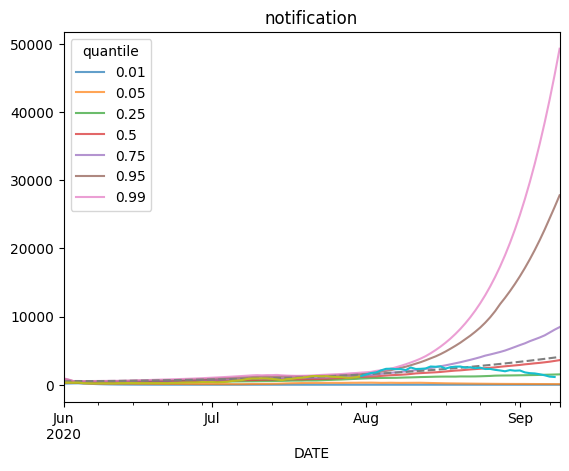

In [273]:
variable = "notification"

fig = uncertainty_df[variable].plot(title=variable,alpha=0.7)
pd.Series(map_res.derived_outputs[variable]).plot(style='--')
notification_data[:61].plot()
notification_data[60:100].plot()

In [338]:
#Using plotly

variable = "notification"
m = map_res.derived_outputs[variable]
fig = go.Figure()
fig = px.line(uncertainty_df[variable])
fig = fig.add_trace(go.Scatter(x = m.keys(), y = m, name = "MLE"))
fig = fig.add_trace(go.Scatter(x = notification_data[:101].keys(), y = notification_data[:101], name = "data"))
fig.show()

/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<Axes: title={'center': 'deaths_cumulative'}, xlabel='DATE'>

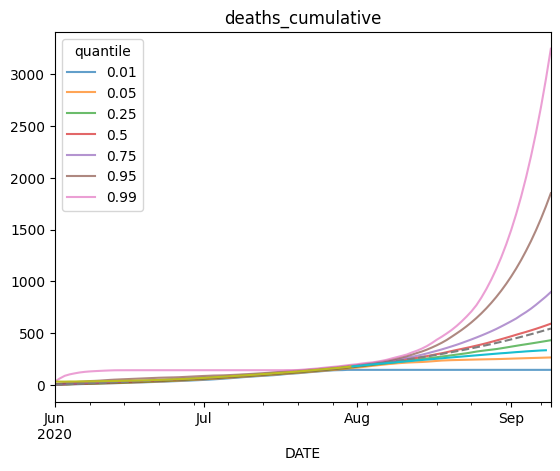

In [274]:
variable = "deaths_cumulative"

fig = uncertainty_df[variable].plot(title=variable,alpha=0.7)
pd.Series(map_res.derived_outputs[variable]).plot(style='--')
death_data[:61].plot()
death_data[60:100].plot()